In [1]:
import DiffusionBridge as db
from DiffusionBridge.utils import normal_logpdf
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader 
from tqdm.notebook import tqdm
from scipy.stats import norm
import plotly.graph_objects as go
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts,StepLR, OneCycleLR

torch.manual_seed(233)
np.random.seed(233)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# problem settings
d = 1
sigma = torch.tensor(1.0)
T = torch.tensor(1.0)
M = 1000
f = None

diffusion = db.diffusion.model(f, sigma, d, T, M)

In [3]:
num_samples = 2000
mu1 = -4
mu2 = 4
sigma = 1
epsilon = 0.001
T = 1


def gen_bridge(x, y, ts, T, num_samples):
    sigma=1
    bridge = torch.zeros((ts.shape[0], num_samples))
    drift = torch.zeros((ts.shape[0], num_samples))
    bridge[0] = x
    for i in range(len(ts) - 1):
        dt = ts[i+1] - ts[i]      # dt = epsilon
        dydt = (y - bridge[i]) / (T - ts[i])
        drift[i, :] = dydt
        diffusion = sigma * torch.sqrt(dt) * torch.randn(num_samples)
        bridge[i+1] = bridge[i] + dydt * dt
        bridge[i+1, :] += diffusion
    return bridge, drift


class gaussian:
    def __init__(self, mu=0, sigma=1) -> None:
        self.mu = mu
        self.sigma = sigma
        pass
    
    def __call__(self, num_samples):
        return torch.normal(self.mu, self.sigma, size=(num_samples,1))

class two_gaussian:
    def __init__(self, mu1=-8, mu2=8,sigma=1) -> None:
        self.mu1 = mu1
        self.mu2 = mu2
        self.sigma = sigma
        pass
    
    def __call__(self, num_samples):
        half_num_samples = num_samples // 2
        samples1 = torch.normal(self.mu1, self.sigma, size=(half_num_samples,1))
        samples2 = torch.normal(self.mu2, self.sigma, size=(num_samples-half_num_samples,1))
        return torch.concatenate([samples1, samples2])
    


# 定义参数
def gen_data(mu1=-10, mu2=10, sigma=1, num_samples=1000, epsilon=0.001, T=1):
    if not isinstance(num_samples, int):
        num_samples = int(num_samples)
    # 生成初始密度的样本 (标准高斯分布)
    initial_density_samples = np.random.normal(0, 1, 2 * num_samples)

    # 生成终止密度的样本 (两个高斯分布)
    target_density_samples1 = np.random.normal(mu1, sigma, num_samples)
    target_density_samples2 = np.random.normal(mu2, sigma, num_samples)
    target_density_samples = np.concatenate([target_density_samples1, target_density_samples2])

    # 返回生成的样本
    ts = torch.arange(0, T+epsilon, epsilon)
    initial_density_samples = torch.Tensor(initial_density_samples)
    target_density_samples = torch.Tensor(target_density_samples)
    bridge, drift = gen_bridge(initial_density_samples, target_density_samples, ts, T=T, num_samples=2*num_samples)
    return ts, bridge, drift, initial_density_samples, target_density_samples

ts, bridge, drift, source_sample, target_sample = gen_data(mu1=mu1, mu2=mu2, sigma=sigma, num_samples=num_samples/2, epsilon=epsilon, T=T)

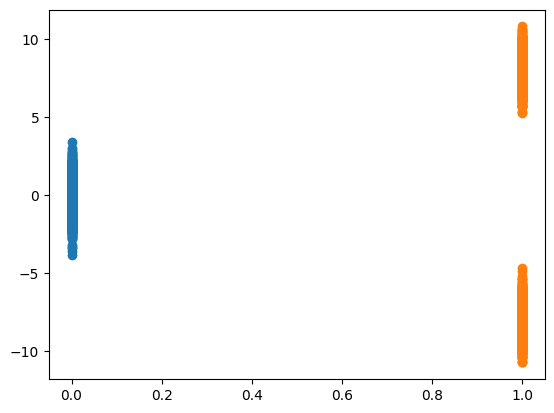

In [4]:
source_dist = gaussian()
target_dist = two_gaussian()
plt.scatter(torch.zeros(num_samples), source_dist(num_samples))
plt.scatter(torch.ones(num_samples), target_dist(num_samples))
plt.show()

In [5]:
XT = []
epsilon = 1e-3
minibatch = 1
num_initial_per_batch = 5000
num_iterations = 2000
learning_rate = 0.01
ema_momentum = 0.99

# output = diffusion.my_learn_full_score_transition(source_dist, 
#                                                   target_dist, 
#                                                   epsilon, 
#                                                   minibatch, 
#                                                   num_initial_per_batch, 
#                                                   num_iterations, 
#                                                   learning_rate, 
#                                                   ema_momentum,
#                                                   scheduler='cos',
#                                                   device=device)
output = diffusion.load_checkpoint('score_transition_net.pt')

In [6]:
score_transition_net = output['net']

In [7]:
torch.save(score_transition_net.state_dict(), 'score_transition_net.pt')

In [8]:
def plot_bridge(ts, bridge, source_sample, target_sample, show_rate=1.0, show_gt=False, title=r'Gaussian to 2$\times$Gaussian'):
    if show_rate < 1.0:
        indices = np.arange(len(source_sample))

        # 打乱索引数组
        np.random.shuffle(indices)

        # 重新排列数组
        source_sample = source_sample[indices]
        target_sample = target_sample[indices]
        bridge = bridge[:, indices]
        
        source_sample = source_sample[:int(len(source_sample) * show_rate)]
        target_sample = target_sample[:int(len(target_sample) * show_rate)]
        bridge = bridge[:, :int(bridge.shape[-1] * show_rate)]
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    ax.scatter(np.zeros_like(source_sample), source_sample, c='r', alpha=0.8, label='Source', s=10)
    ax.scatter(np.ones_like(target_sample), target_sample, c='g', alpha=0.8, label='Target', s=10)
    # ax.plot(ts, bridge, c='gray', alpha=0.3)
    
    for i in range(bridge.shape[1]):
        line_color = 'orange' if bridge[-1, i] > 0 else 'blue'
        plt.plot(ts, bridge[:, i], color=line_color, alpha=0.3)
    
    if show_gt:
        # 计算 X1, Y1, X2, Y2
        X1 = np.zeros_like(source_sample)
        Y1 = source_sample
        X2 = np.ones_like(target_sample)
        Y2 = target_sample

        for i in range(X1.shape[0]):
            plt.plot([X1[i, 0], X2[i, 0]], [Y1[i, 0], Y2[i, 0]], color='gray',alpha=0.3)

         
    ax.set_title(title)
    ax.legend()
    fig.show()
    return fig, ax

# plot_bridge(ts, bridge, source_sample, target_sample, show_rate=1)

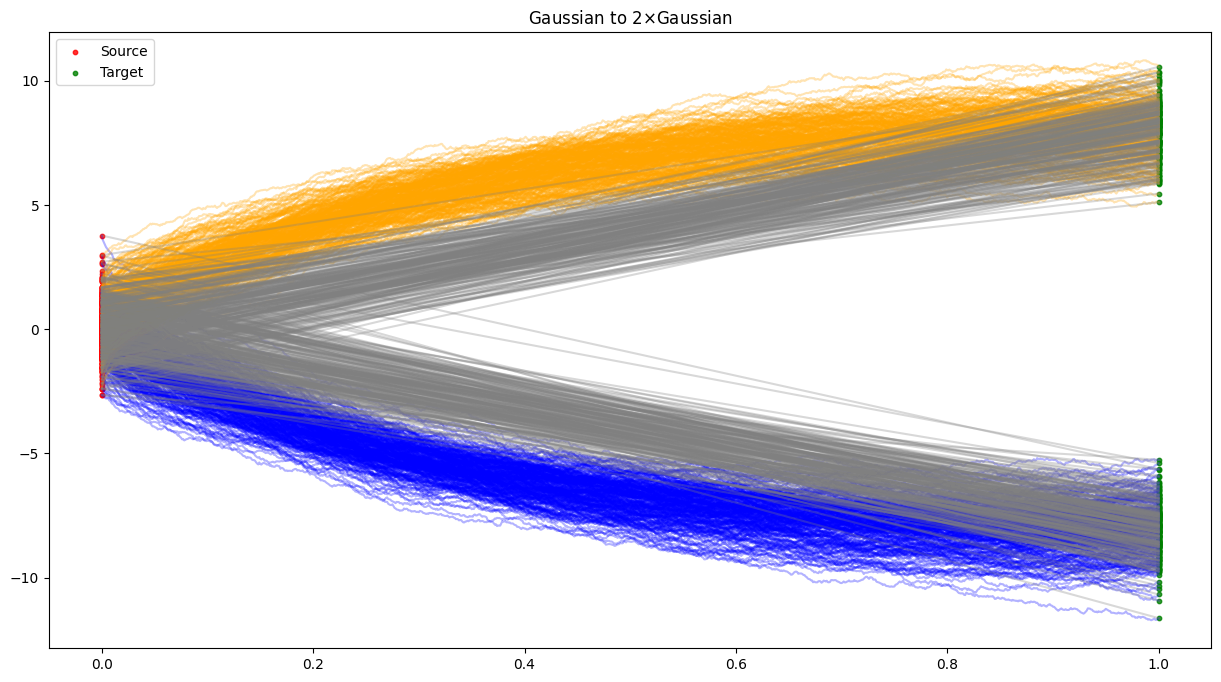

In [9]:
score_transition_net = score_transition_net.cpu()
num_test_samples = 500
source_sample = source_dist(num_test_samples)
target_sample = target_dist(num_test_samples)
out = diffusion.my_simulate_bridge_backwards(score_transition_net, source_sample, target_sample, 1e-3, modify = True, full_score = True)

fig, ax = plot_bridge(diffusion.time.numpy(), out['trajectories'][:,:,0].detach().numpy().T, source_sample.numpy(), target_sample.numpy(), show_rate=1, show_gt=True)
fig.show()

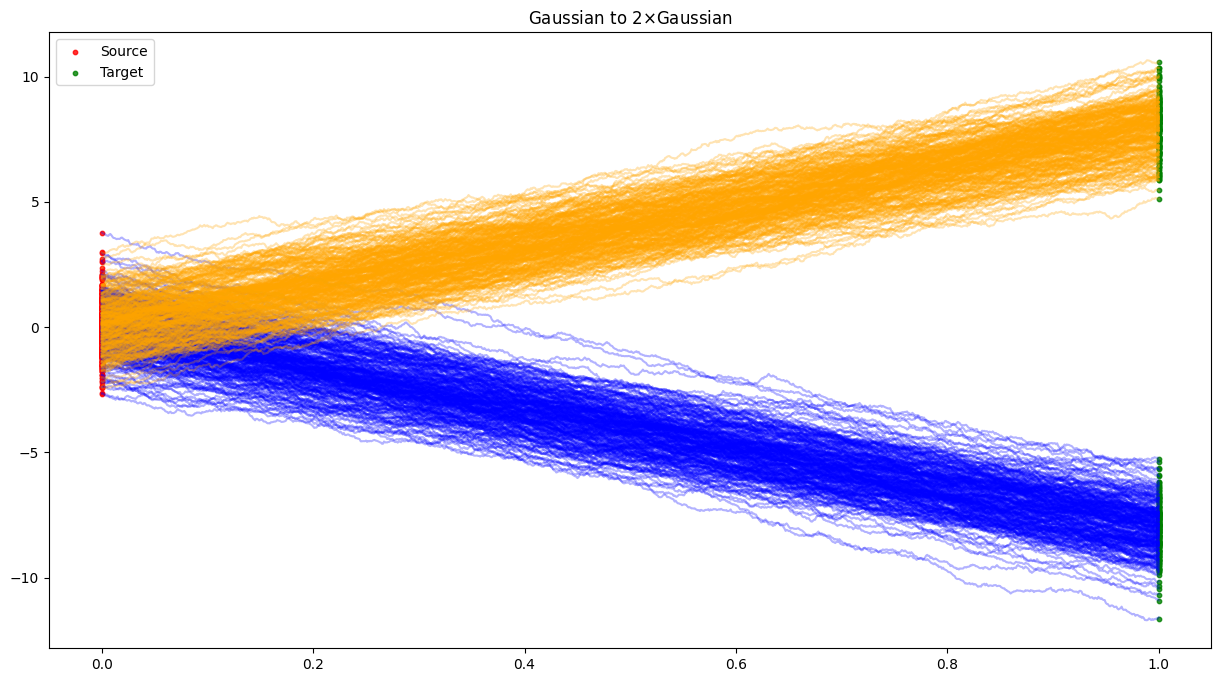

In [10]:
out = diffusion.my_simulate_process(source_sample, target_sample)
fig, ax = plot_bridge(diffusion.time.numpy(), out['trajectories'][:,:,0].detach().numpy().T, source_sample.numpy(), target_sample.numpy(), show_rate=1, show_gt=False)
fig.show()

In [11]:
f = lambda x, t: 0
diffusion.f =  f

In [12]:
out = diffusion.my_learn_score_marginal(score_transition_net, source_dist, target_dist, epsilon, minibatch, num_initial_per_batch, num_iterations, learning_rate, ema_momentum, scheduler='cos')


Output()

NameError: name 'd' is not defined